In [8]:
import sys, os
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [9]:
# 1. Инициализация среды
env = gym.make("Taxi-v3")
env.reset()
env.render()
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states=%i, n_actions=%i" % (n_states, n_actions))

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_reso

n_states=500, n_actions=6


In [10]:
# 2. Создание стохастической политики
def initialize_policy(n_states, n_actions):
    # Создаем двумерный массив с равномерным распределением вероятностей
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

policy = initialize_policy(n_states, n_actions)
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


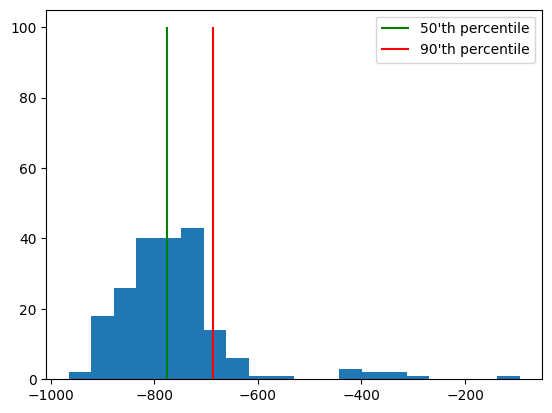

In [11]:
# 3. Игра с моделью
def generate_session(env, policy, t_max=10**4):
    """
    Играть до конца или t_max тиков.
    :param policy: массив вида [n_states, n_actions] с вероятностями действий
    :returns: список состояний, список действий и сумма наград
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()
    for t in range(t_max):
        # Выбираем действие на основе вероятностной политики
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s

        if done:
            break

    return states, actions, total_reward

s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]
# Визуализация начального распределения вознаграждения
sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()
plt.show()


In [12]:
# 4. Шаги кросс-энтропийного метода
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Выберите состояния и действия из игры, которые имеют награды >= процентиль
    """
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = [s for i, reward in enumerate(rewards_batch) if reward >= reward_threshold for s in states_batch[i]]
    elite_actions = [a for i, reward in enumerate(rewards_batch) if reward >= reward_threshold for a in actions_batch[i]]
    return elite_states, elite_actions

states_batch = [
    [1, 2, 3],
    [4, 2, 0, 2],
    [3, 1],
]
actions_batch = [
    [0, 2, 4],
    [3, 2, 0, 1],
    [3, 3],
]
rewards_batch = [
    3,
    4,
    5,
]

def get_new_policy(elite_states, elite_actions):
    """
    Учитывая список лучших состояний/действий, возвращает новую политику
    """
    new_policy = np.zeros([n_states, n_actions])
    elite_counts = defaultdict(int)

    for s, a in zip(elite_states, elite_actions):
        elite_counts[(s, a)] += 1

    for s in range(n_states):
        for a in range(n_actions):
            new_policy[s, a] = elite_counts[(s, a)]

        if np.sum(new_policy[s]) == 0:
            new_policy[s] = 1 / n_actions
        else:
            new_policy[s] /= np.sum(new_policy[s])

    return new_policy

mean reward = -100.200, threshold=6.000


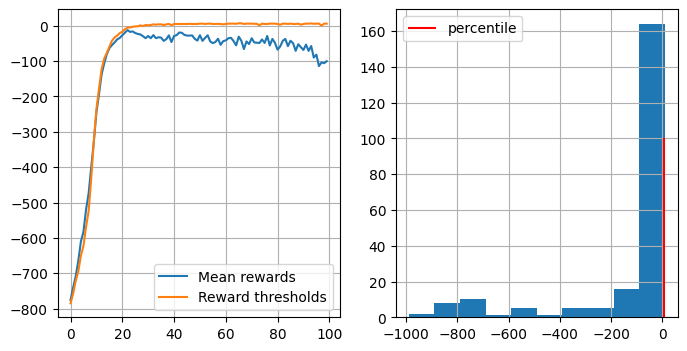

In [13]:
# 5. Тренировочный цикл
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

policy = initialize_policy(n_states, n_actions)
n_sessions = 250
percentile = 50
learning_rate = 0.5
log = []

for i in range(100):
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    show_progress(rewards_batch, log, percentile)